In [1]:
from os import getcwd, path
import sys

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

In [2]:
MODEL_PATH = path.join(BASE_PATH, 'output/model/checkpoint_50_77.82.bin')
print(MODEL_PATH)

/Users/2359media/Documents/botbot-nlp/output/model/checkpoint_50_77.82.bin


In [3]:
import torch
from sent_to_vec.model import *

ENCODER_DIM = 2400
encoder = QRNNEncoder(hidden_dim=ENCODER_DIM)
nli_net = NLINet(encoder=encoder, lstm_dim=ENCODER_DIM, bidirectional_encoder=False)
nli_net.load_state_dict(torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)['nli_state'])

In [4]:
def encode(sent):
    sent_input = process_input([sent])
    print(sent_input)
    sent_batch, sent_len = process_batch(sent_input)
    encoder.eval()
    embs = encoder((sent_batch, sent_len))
    encoder.train()
    return embs.data.numpy()

target_dict = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
target_dict = {v:k for k, v in target_dict.items()} # invert
def test(sent1, sent2):
    sent1 = process_input([sent1, 'filler sentence'])
    sent2 = process_input([sent2, 'filler sentence'])
    sent1_batch = process_batch(sent1)
    sent2_batch = process_batch(sent2)
    nli_net.eval()
    result = nli_net(sent1_batch, sent2_batch)
    nli_net.train()
    scores, idxs = torch.max(result, dim=-1)
    print(scores[0])
#     print(idxs)
    return target_dict[idxs.data.numpy()[0]]

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [5]:
embs = encode('I\'d like to order a coffee')
print(embs)
print(embs.size)

[['<START>', 'I', "'d", 'like', 'to', 'order', 'a', 'coffee', '<STOP>']]
[-0.00170491 -0.0144889   0.01035676 ...  0.00157192 -0.01595983
 -0.02341213]
2400


In [6]:
cosine(encode('Hello!'), encode('Good morning!'))

[['<START>', 'Hello', '!', '<STOP>']]
[['<START>', 'Good', 'morning', '!', '<STOP>']]


0.87077105

In [7]:
cosine(encode('How do I search Google?'), encode('How do I perform a web search?'))

[['<START>', 'How', 'do', 'I', 'search', 'Google', '?', '<STOP>']]
[['<START>', 'How', 'do', 'I', 'perform', 'a', 'web', 'search', '?', '<STOP>']]


0.89508873

In [8]:
cosine(encode('I want to go outside'), encode('She wants to stay home'))

[['<START>', 'I', 'want', 'to', 'go', 'outside', '<STOP>']]
[['<START>', 'She', 'wants', 'to', 'stay', 'home', '<STOP>']]


0.74489516

In [9]:
cosine(encode('The weather is nice today'), encode('I want to go buy some food'))

[['<START>', 'The', 'weather', 'is', 'nice', 'today', '<STOP>']]
[['<START>', 'I', 'want', 'to', 'go', 'buy', 'some', 'food', '<STOP>']]


0.5321972

In [10]:
cosine(encode('This church choir sings to the masses as they sing joyous songs from the book at a church . '), encode('The church is filled with song . '))

[['<START>', 'This', 'church', 'choir', 'sings', 'to', 'the', 'masses', 'as', 'they', 'sing', 'joyous', 'songs', 'from', 'the', 'book', 'at', 'a', 'church', '.', '<STOP>']]
[['<START>', 'The', 'church', 'is', 'filled', 'with', 'song', '.', '<STOP>']]


0.6234433

In [11]:
cosine(encode('This church choir sings to the masses as they sing joyous songs from the book at a church . '), encode('The church has cracks in the ceiling .'))

[['<START>', 'This', 'church', 'choir', 'sings', 'to', 'the', 'masses', 'as', 'they', 'sing', 'joyous', 'songs', 'from', 'the', 'book', 'at', 'a', 'church', '.', '<STOP>']]
[['<START>', 'The', 'church', 'has', 'cracks', 'in', 'the', 'ceiling', '.', '<STOP>']]


0.5911627

In [12]:
test('This church choir sings to the masses as they sing joyous songs from the book at a church . ', 
     'The church is filled with song . ')

tensor(1.2094)


'entailment'

In [13]:
test('This church choir sings to the masses as they sing joyous songs from the book at a church . ', 
     'The church has cracks in the ceiling .')

tensor(0.8897)


'contradiction'

[[6 0 6 ... 3 0 5]]
2400


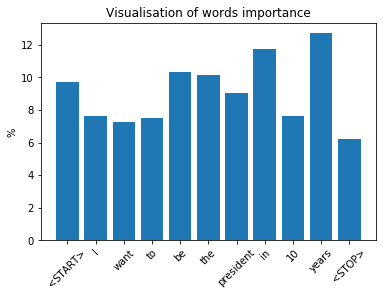

In [16]:
import matplotlib.pyplot as plt

sent_input = ['I want to be the president in 10 years']
sent_input = process_input(sent_input)
sent_batch, sent_len = process_batch(sent_input)

encoder.eval()
output = encoder.qrnn(sent_batch)[0]
encoder.train()
output, idxs = torch.max(output, 0)
idxs = idxs.data.numpy()
print(idxs)
print(idxs.size)

x = range(len(sent_input[0]))
argmaxs = [np.sum((idxs == k)) for k in range(len(sent_input[0]))]
y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
plt.xticks(x, sent_input[0], rotation=45)
plt.bar(x, y)
plt.ylabel('%')
plt.title('Visualisation of words importance')
plt.show()